In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report,roc_auc_score,precision_score, recall_score, f1_score
import warnings
from sklearn.exceptions import ConvergenceWarning

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/stroke data.csv")
df.head()

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
0,1,Male,3.0,No,0,0,A,Rural,95.12,18.0,1,99.35,95.12,NaN,0
1,2,Male,58.0,Yes,1,0,B,Urban,87.96,39.2,1,99.70,87.96,never smoked,0
2,3,Female,8.0,No,0,0,B,Urban,110.89,17.6,0,96.35,110.89,NaN,0
3,4,Female,70.0,Yes,0,0,B,Rural,69.04,35.9,0,95.52,69.04,formerly smoked,0
4,5,Male,14.0,No,0,0,C,Rural,161.28,19.1,1,95.10,161.28,NaN,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              43400 non-null  int64  
 1   gender          43400 non-null  object 
 2   age             43400 non-null  float64
 3   married         43400 non-null  object 
 4   hypertension    43400 non-null  int64  
 5   heart_disease   43400 non-null  int64  
 6   occupation      43400 non-null  object 
 7   residence       43400 non-null  object 
 8   metric_1        43400 non-null  float64
 9   metric_2        41938 non-null  float64
 10  metric_3        43400 non-null  int64  
 11  metric_4        43400 non-null  float64
 12  metric_5        43400 non-null  float64
 13  smoking_status  30108 non-null  object 
 14  stroke          43400 non-null  int64  
dtypes: float64(5), int64(5), object(5)
memory usage: 5.0+ MB


In [ ]:
df.describe()

,id,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,metric_5,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000,43400.000000,43400.000000,43400.000000
mean,21700.500000,42.261212,0.093571,0.047512,104.482750,28.605038,0.289931,97.526855,104.482750,0.018041
std,12528.645178,23.438911,0.291235,0.212733,43.111751,7.770020,0.453735,1.466703,43.111751,0.133103
min,1.000000,-10.000000,0.000000,0.000000,55.000000,10.100000,0.000000,87.420000,55.000000,0.000000
25%,10850.750000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000,96.590000,77.540000,0.000000
50%,21700.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000,97.610000,91.580000,0.000000
75%,32550.250000,60.000000,0.000000,0.000000,112.070000,32.900000,1.000000,98.700000,112.070000,0.000000
max,43400.000000,1000.000000,1.000000,1.000000,291.050000,97.600000,1.000000,100.000000,291.050000,1.000000


In [ ]:
df['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

**Dataset is imbalanced and an oversampling technique like SMOTE will have to be used to get good predictive performance on the dataset**

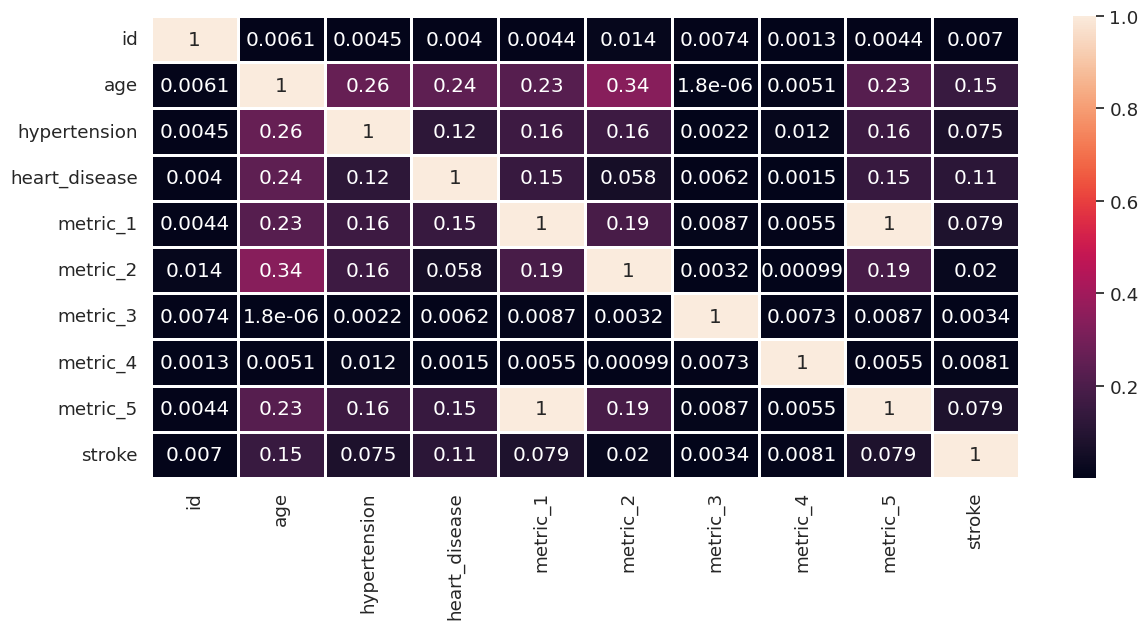

In [ ]:
plt.figure(figsize=(14,6))
corr=abs(df.corr())
sns.heatmap(corr,annot=True,linewidth=1)
plt.show()

In [ ]:
# Percent missing values for each column
per_missing = (df.isna().sum()/len(df))*100
print(per_missing)

id                 0.000000
gender             0.000000
age                0.000000
married            0.000000
hypertension       0.000000
heart_disease      0.000000
occupation         0.000000
residence          0.000000
metric_1           0.000000
metric_2           3.368664
metric_3           0.000000
metric_4           0.000000
metric_5           0.000000
smoking_status    30.626728
stroke             0.000000
dtype: float64


**Smoking status has 30% percent missing values. In this scenario, dropping na values or going for standard imputation is not feasible. Thus, na values will be replaced with 'Unknown' for this column. For metric_2 with 3 percent missing values, Knn imputation will be performed**

In [ ]:
cols = df.columns
for col in cols:
  print(df[col].value_counts())

1        1
28937    1
28929    1
28930    1
28931    1
        ..
14469    1
14470    1
14471    1
14472    1
43400    1
Name: id, Length: 43400, dtype: int64
Female    25665
Male      17724
Other        11
Name: gender, dtype: int64
 51.00      738
 52.00      721
 53.00      701
 78.00      698
 50.00      694
           ... 
 0.16        26
 0.08        17
 1000.00      1
-10.00        1
 999.00       1
Name: age, Length: 107, dtype: int64
Yes    27938
No     15462
Name: married, dtype: int64
0    39339
1     4061
Name: hypertension, dtype: int64
0    41338
1     2062
Name: heart_disease, dtype: int64
B    24834
D     6793
A     6156
E     5440
C      177
Name: occupation, dtype: int64
Urban    21756
Rural    21644
Name: residence, dtype: int64
82.71     19
87.07     18
72.53     18
83.92     17
84.49     17
          ..
144.15     1
119.98     1
188.26     1
252.75     1
132.22     1
Name: metric_1, Length: 12543, dtype: int64
27.7    271
27.6    267
26.8    266
26.1    265
27.1   

In [ ]:
df['gender'].value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [ ]:
# Dropping rows with gender equal to 'Other' to avoid mismatch in train test split
df = df[(df['gender'] == 'Female') | (df['gender'] == 'Male')]

In [ ]:
# Changing age column to integer type and dropping unrealistic values
# Dropping rows where age value is not integer
df = df[np.floor(df['age']) == df['age']]
df['age'] = df['age'].astype('int64')
df = df[(df['age'] > 0) & (df['age'] < 120)]

<ipython-input-205-6e0769f64bdd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = df['age'].astype('int64')


In [ ]:
# Metric_3, hypertension and heart_disease only take binary values so converting them to categorical type
df['metric_3'] = df['metric_3'].astype(object)
df['hypertension'] = df['hypertension'].astype(object)
df['heart_disease'] = df['heart_disease'].astype(object)

DATA VISUALIZATION

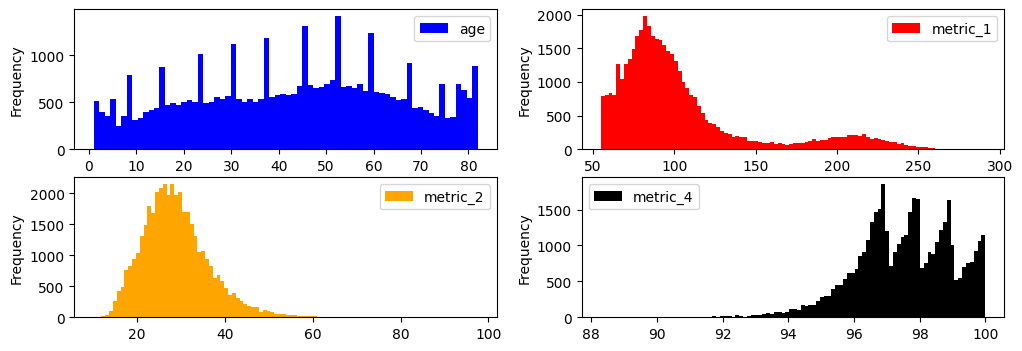

In [ ]:
# Checking distribution of variables by histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))

df.plot(kind="hist", y="age", bins=70, color="b", ax=axes[0, 0])


df.plot(kind="hist", y ="metric_1", bins=100, color="r", ax=axes[0, 1])


df.plot(kind="hist", y="metric_2", bins=100,color="orange", ax=axes[1, 0])


df.plot(kind="hist", y="metric_4",bins=100, color="black", ax=axes[1, 1])


# Display the plots
plt.show()

**metric_2 has a normal distribution while metric_1 and metric_4 have skewed distributions**

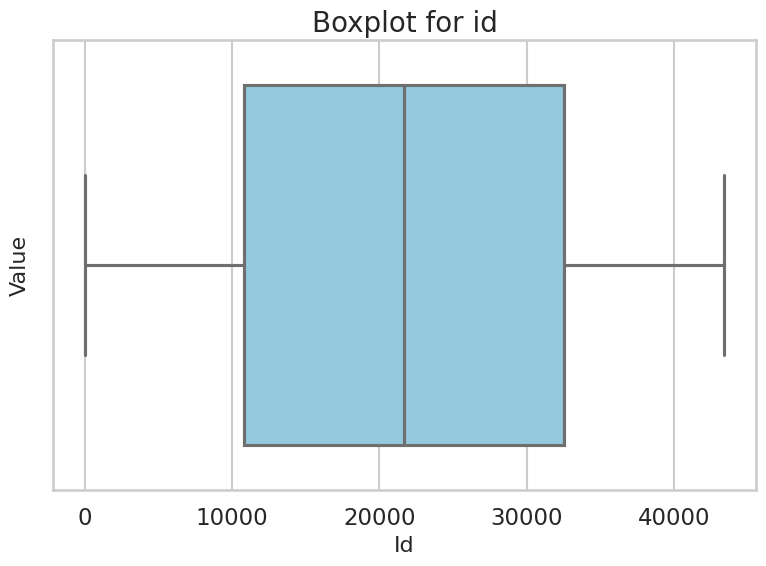

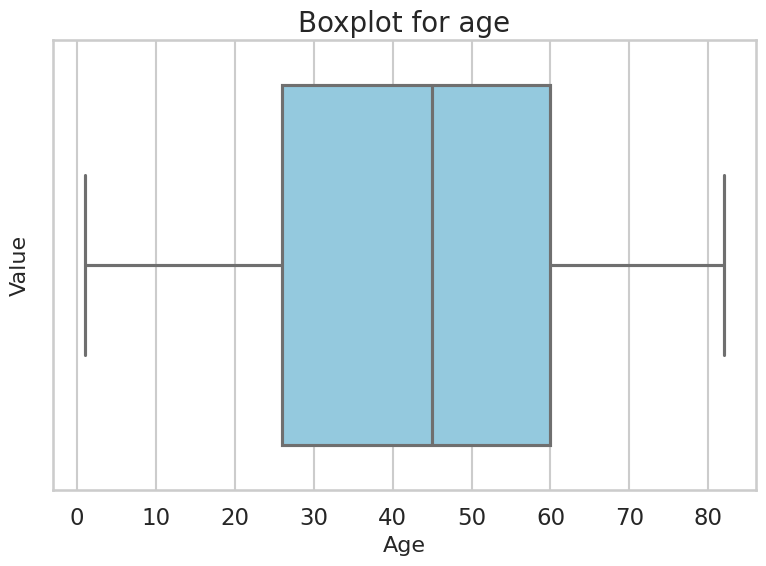

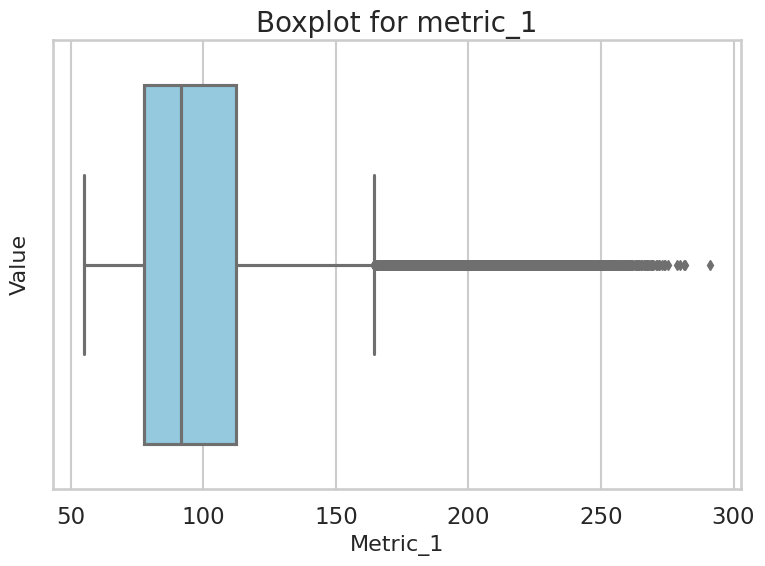

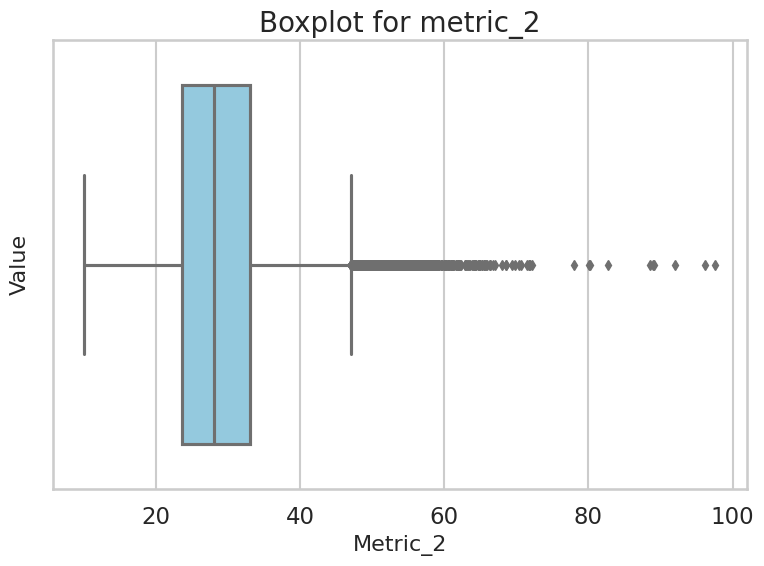

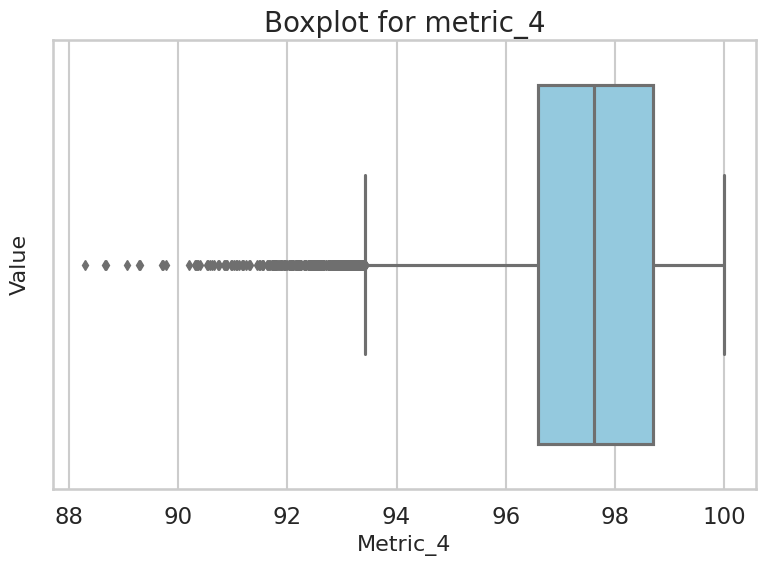

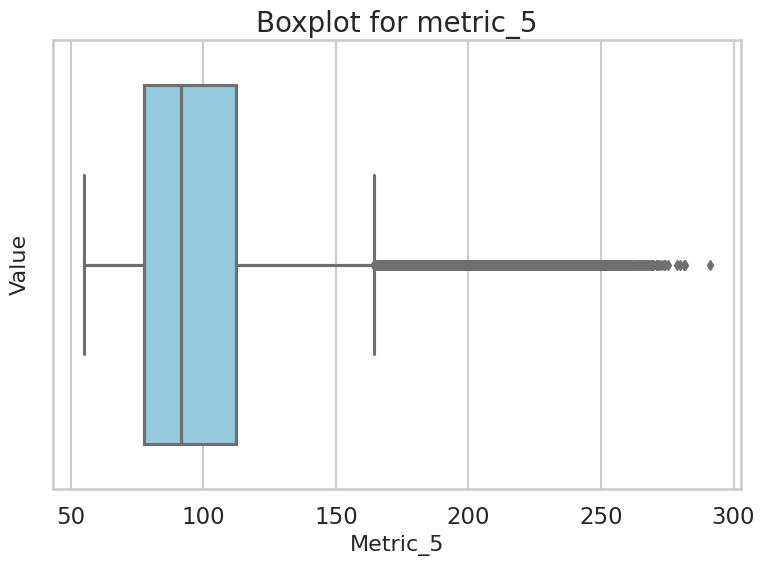

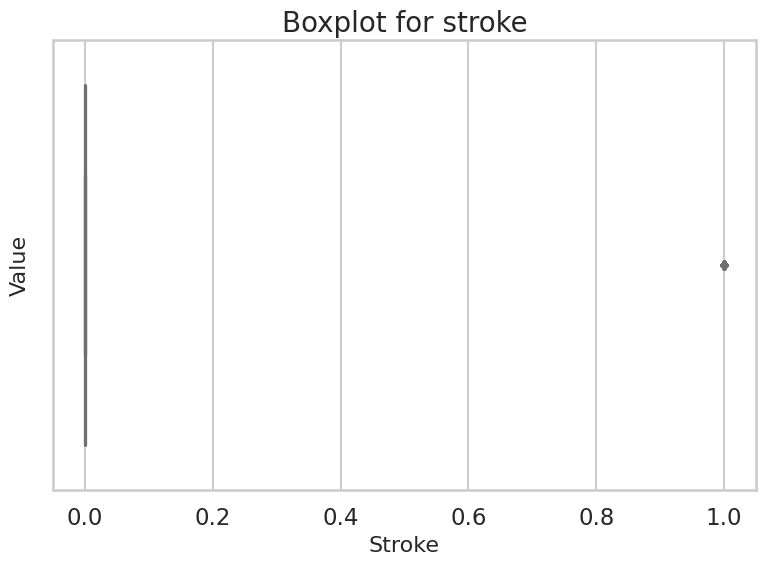

In [ ]:
# Plotting boxplots to get sense of outliers
num_cols = df.select_dtypes(exclude='object').columns

sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.set_context("talk")

# Create a boxplot for each numeric column
for col in num_cols:
    fig, ax = plt.subplots(figsize=(8,6))
    sns.boxplot(data=df, x=col, ax=ax, color="skyblue")
    ax.set_xlabel(col.capitalize(), fontsize=16)
    ax.set_ylabel("Value", fontsize=16)
    ax.set_title(f"Boxplot for {col}", fontsize=20)
    plt.tight_layout()
    plt.show()

**Metric_1, Metric_2, Metric_4 and Metric_5 all possess significant outlier values. **

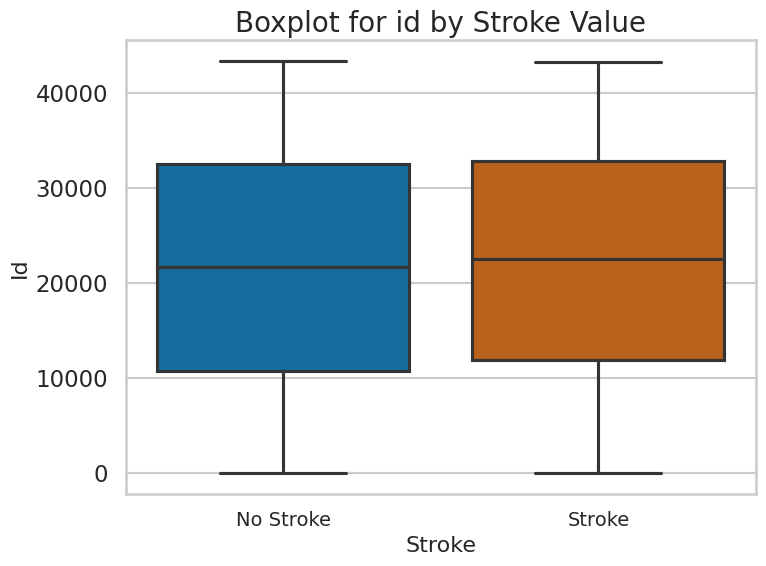

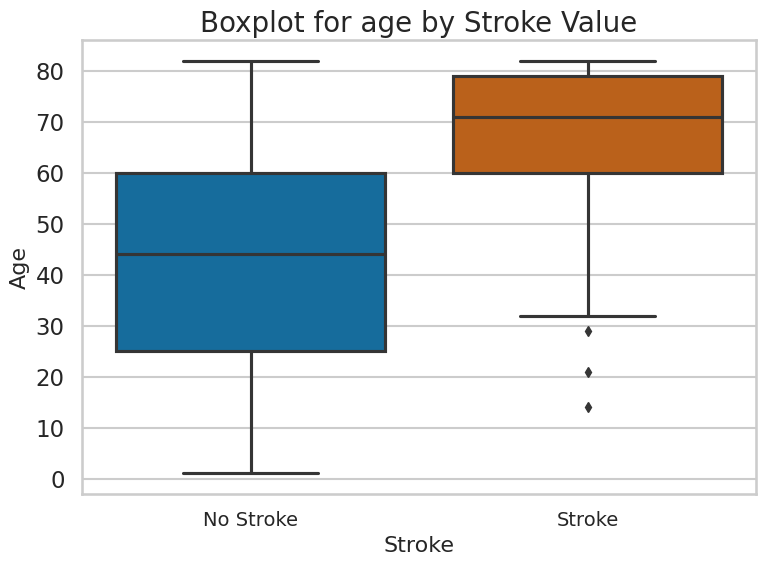

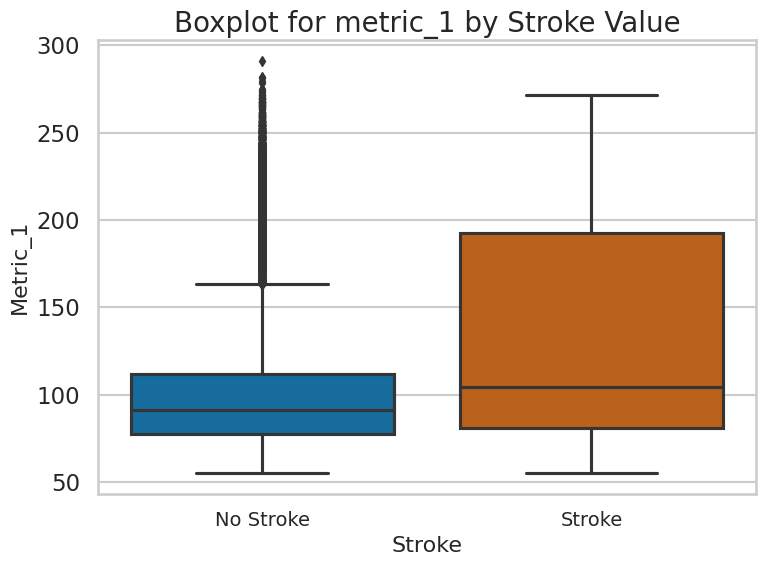

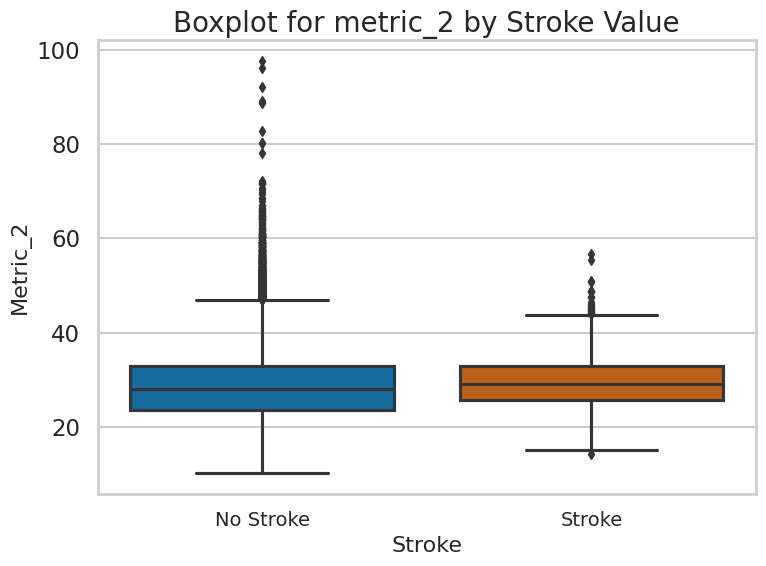

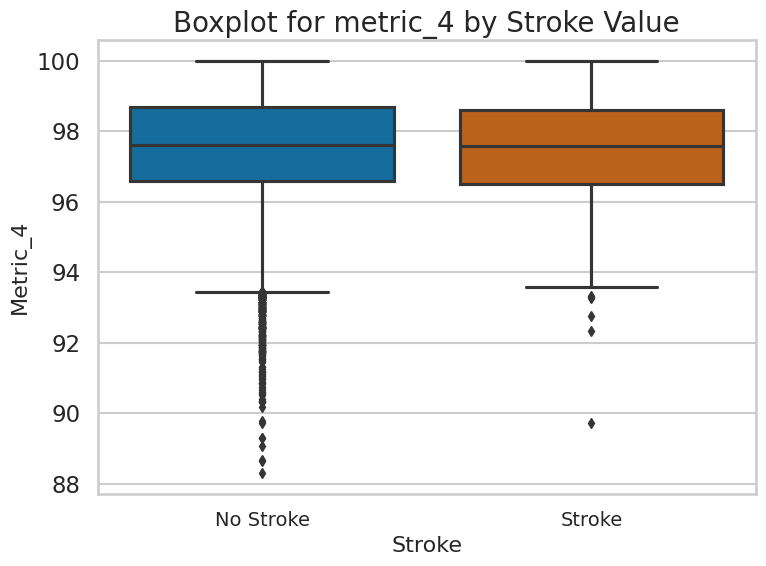

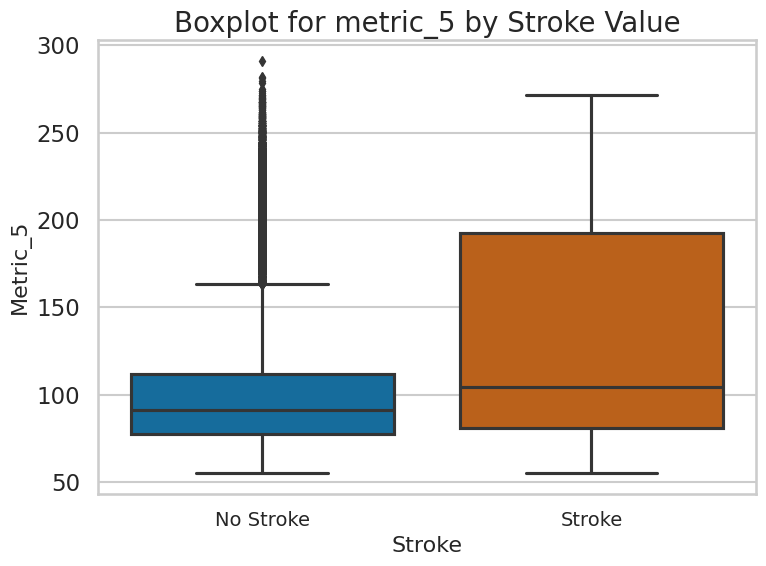

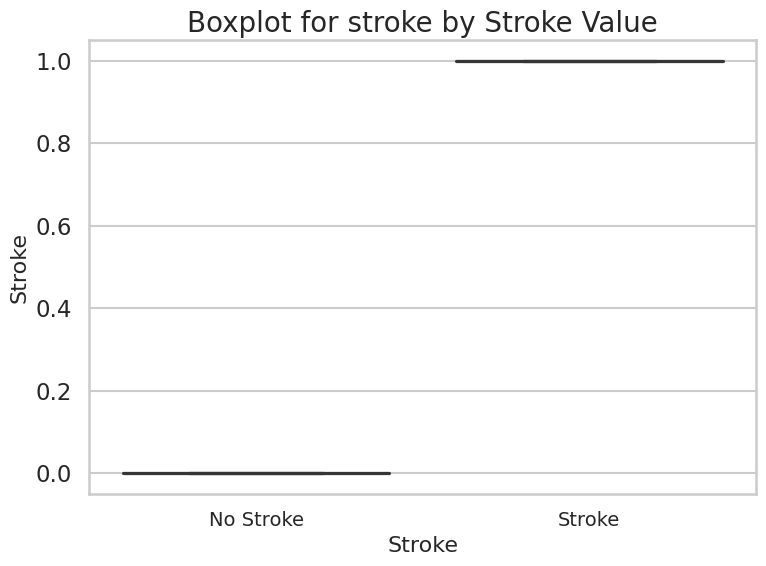

In [ ]:
# Boxplots by stroke value to detect disparities in values of metrics for healthy and people with stroke.
num_cols = df.select_dtypes(exclude='object').columns

sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.set_context("talk")

for col in num_cols:
    fig, ax = plt.subplots(figsize=(8,6))
    sns.boxplot(data=df, x="stroke", y=col, ax=ax, palette=["#0072B2", "#D55E00"])
    ax.set_xlabel("Stroke", fontsize=16)
    ax.set_ylabel(col.capitalize(), fontsize=16)
    ax.set_title(f"Boxplot for {col} by Stroke Value", fontsize=20)
    ax.set_xticklabels(["No Stroke", "Stroke"], fontsize=14)
    plt.tight_layout()
    plt.show()

**From Boxplots of Age, Metric_1 and Metric_5, it is quite evident that the values of these metrics for people with stroke are much higher than for healthy people**

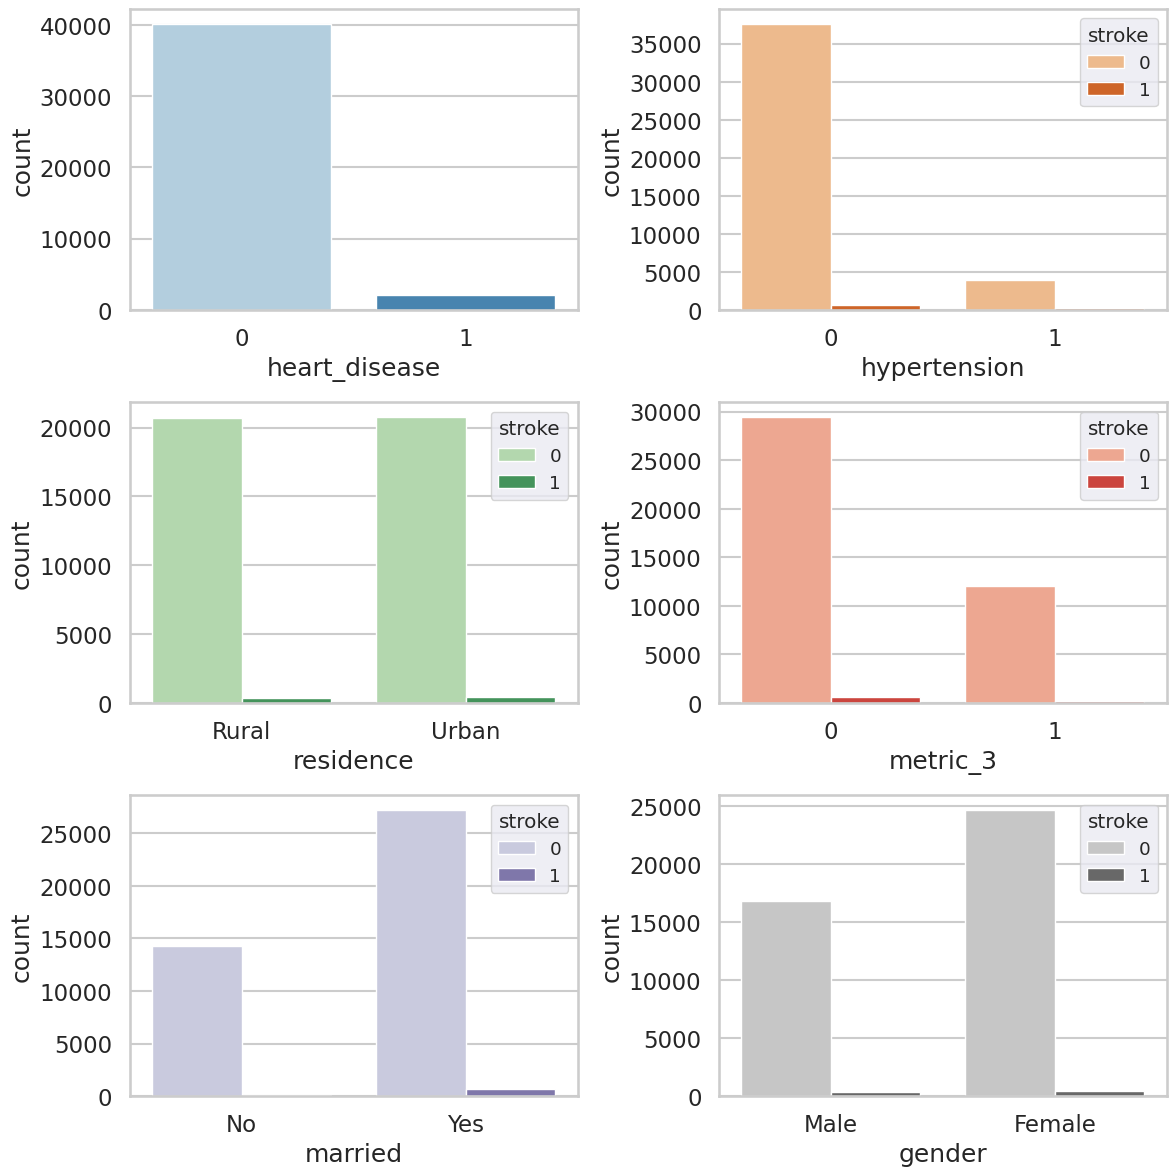

In [ ]:
# Countplots for categorical columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

sns.set(font_scale=1.2)

# Create the countplots
sns.countplot(x="heart_disease", data=df, ax=axes[0, 0], palette="Blues")
sns.countplot(x="hypertension", hue="stroke", data=df, ax=axes[0, 1], palette="Oranges")
sns.countplot(x="residence", hue="stroke", data=df, ax=axes[1, 0], palette="Greens")
sns.countplot(x="metric_3", hue="stroke", data=df, ax=axes[1, 1], palette="Reds")
sns.countplot(x="married", hue="stroke", data=df, ax=axes[2, 0], palette="Purples")
sns.countplot(x="gender", hue="stroke", data=df, ax=axes[2, 1], palette="Greys")

plt.tight_layout()
# Display the plots
plt.show()

**From the above plots, it can be seen that occurence of heart disease, being married and the variable signified by column 'metric_3' play a important role in occurence of stroke. **

In [ ]:
# Dropping id column
df.drop('id',axis=1,inplace=True)

In [ ]:
# Defining X and Y
X = df.drop('stroke',axis=1)
Y = df['stroke']

In [ ]:
# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,stratify=df['stroke'],random_state=42)


In [ ]:
# Getting IQR and upper and lower bounds for outlier removal
def bounds(df,col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  IQR = q3-q1
  low = q1 - 1.5*IQR
  up = q3 + 1.5*IQR
  return low,up

In [ ]:
def outlier_treatment(X_train, Y_train):
  # Choosing columns for outlier removal based on boxplots.
  # Columns with outliers with low values 
  out_col_lower = ['metric_4']
  # Columns with outliers with high values
  out_col_upper = ['metric_1','metric_2','metric_5']
  out_col = [x for x in out_col_lower or out_col_upper]
  for col in out_col:
    low, up = bounds(X_train, col)
    if col in out_col_lower:
      potential_outliers = X_train[col] < low
    else:
      potential_outliers = X_train[col] > up
    X_train = X_train[~potential_outliers]
    Y_train = Y_train[~potential_outliers]
  return X_train,Y_train
X_train, Y_train = outlier_treatment(X_train, Y_train)


In [ ]:
# KNN Imputation for missing values
def imputation(X_train, X_test):
    # List of columns with missing values
    col_missing = X_train.columns[X_train.isna().any()].tolist()
    for col in col_missing:
        if col=="smoking_status":
          # Replace na values in smoking column with 'Unknown'
          X_train[col] = X_train[col].replace(np.nan, 'Unknown')
          X_test[col] = X_test[col].replace(np.nan, 'Unknown')
          continue
        imputer = KNNImputer()
        X_train[col] = imputer.fit_transform(X_train[col].values.reshape(-1, 1))[:, 0]
        X_test[col] = imputer.transform(X_test[col].values.reshape(-1, 1))[:, 0]
    return X_train, X_test

X_train, X_test = imputation(X_train, X_test)


In [ ]:
def scaling(X_train,X_test):
  # Using StandardScaler for scaling
  sc = StandardScaler()
  num_col = X_train.select_dtypes(exclude='object').columns
  cat_col = [x for x in X_train.columns if x not in num_col]
  X_train_cat = X_train[cat_col]
  X_train[num_col] = sc.fit_transform(X_train[num_col])
  X_train = pd.concat([X_train[num_col],X_train_cat],axis=1)
  X_test_cat = X_test[cat_col]
  X_test[num_col] = sc.transform(X_test[num_col])
  X_test = pd.concat([X_test[num_col],X_test_cat],axis=1)
  return X_train, X_test
X_train, X_test = scaling(X_train, X_test)

In [ ]:
def feature_encoding(df):
  cat_col = df.select_dtypes(include='object').columns
  df = pd.get_dummies(df, columns= cat_col, drop_first=True)
  return df
X_train = feature_encoding(X_train)
X_test = feature_encoding(X_test)




/usr/local/lib/python3.9/dist-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/usr/local/lib/python3.9/dist-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [ ]:
def smote(X,Y):
  # Using SMOTE to deal with imbalanced nature of dataset
  smote = SMOTE()
  X_resampled, Y_resampled = smote.fit_resample(X,Y)
  return X_resampled, Y_resampled
X_train, Y_train = smote(X_train, Y_train)


In [ ]:
def feature_selection(X_train, X_test):
  # Checking for correlation among predictor variables and correlation between predictor and target variable
  # Dropping predictor columns with correlation greater than 0.8  
  corr_matrix = X_train.corr().abs()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
  corr = X_train.corrwith(Y_train)
  for key, val in corr.items():
  # Dropping predictor columns with correlation with target variable less than 0.08
    if abs(val) < 0.08:
      to_drop.append(key)
  X_train.drop(to_drop, axis=1, inplace=True)
  X_test.drop(to_drop, axis=1, inplace=True)
feature_selection(X_train, X_test)








<ipython-input-216-d8cf31f578d0>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


MODELING

In [ ]:
# Logistic Regression
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
lr = LogisticRegression()

# Define the hyperparameter grid to search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
}

# Define the GridSearchCV object
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='f1')

# Fit the GridSearchCV object to the training data
grid.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid.best_params_)

# Get the best estimator and predict the test data
best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_test)

# Calculate F1 score
print(classification_report(Y_test,y_pred))
print(roc_auc_score(Y_test,y_pred))

Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      8303
           1       0.05      0.73      0.09       156

    accuracy                           0.74      8459
   macro avg       0.52      0.74      0.47      8459
weighted avg       0.98      0.74      0.84      8459

0.7367564087123283


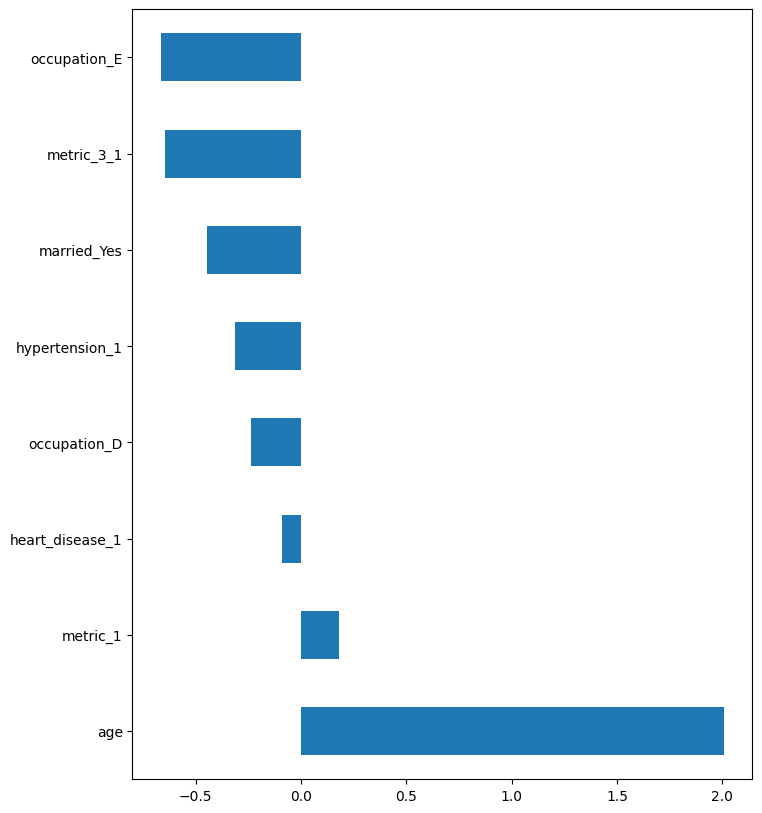

In [ ]:
# Plotting Feature Importance for Logistic Regression Model
Coef = pd.Series(best_lr.coef_[0], index=X_train.columns)  

imp_Coef = Coef.sort_values(ascending=False)
#Visualization
plt.rcParams['figure.figsize'] = (8.0, 10.0)

imp_Coef.plot(kind = "barh")
plt.show()

In [ ]:
# Storing results for comparing different models
results = pd.DataFrame(columns = ['Algorithm','Precision','Recall','F1 Score',
                                 'ROC-AUC Score'])
results.loc[len(results)] = ['Logistic Regression',precision_score(Y_test,y_pred,average='weighted'), recall_score(Y_test, y_pred,average='weighted'), f1_score(Y_test,y_pred, average='weighted'),roc_auc_score(Y_test, y_pred)]

In [ ]:
# Using PCA for feature extraction
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_pca, Y_train)
y_pred = lr.predict(X_test_pca)
print(classification_report(Y_test,y_pred))
print(roc_auc_score(Y_test,y_pred))


              precision    recall  f1-score   support

           0       0.99      0.73      0.84      8303
           1       0.05      0.73      0.09       156

    accuracy                           0.73      8459
   macro avg       0.52      0.73      0.46      8459
weighted avg       0.98      0.73      0.83      8459

0.728867693790011


In [ ]:
results.loc[len(results)] = ['Logistic Regression with PCA',precision_score(Y_test,y_pred,average='weighted'), recall_score(Y_test, y_pred,average='weighted'), f1_score(Y_test,y_pred, average='weighted'),roc_auc_score(Y_test, y_pred)]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
params = {'n_estimators': [ 20, 40, 80, 100,],'max_depth': [ 5, 10, 20],'min_samples_split': [2, 4, 8, 12],}

            # instantiating RandomizedSearchCV
RCV = RandomizedSearchCV(estimator=RF,param_distributions=params,
                                     n_iter=5,
                                     scoring='r2',
                                     cv=5,
                                     verbose=5,
                                     random_state=42,
                                     n_jobs=-1,
                                     return_train_score=True)

RCV.fit(X_train,Y_train)
RF = RCV.best_estimator_

# fitting on the train data
RF.fit(X_train,Y_train)
y_pred = RF.predict(X_test)
print(classification_report(Y_test,y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      8303
           1       0.05      0.37      0.09       156

    accuracy                           0.86      8459
   macro avg       0.52      0.62      0.51      8459
weighted avg       0.97      0.86      0.91      8459



In [ ]:
results.loc[len(results)] = ['Random Forest',precision_score(Y_test,y_pred,average='weighted'), recall_score(Y_test, y_pred,average='weighted'), f1_score(Y_test,y_pred, average='weighted'),roc_auc_score(Y_test, y_pred)]

In [ ]:
# XGBoost 
xgb_model = xgb.XGBClassifier()

# Define the hyperparameters to tune
params = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Define the GridSearchCV object
grid = GridSearchCV(xgb_model, params, cv=3, verbose=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid.fit(X_train, Y_train)

# Print the best hyperparameters
best_xg = grid.best_estimator_
y_pred = best_xg.predict(X_test)

# Calculate F1 score
print(classification_report(Y_test,y_pred))
print(roc_auc_score(Y_test,y_pred))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8303
           1       0.08      0.06      0.07       156

    accuracy                           0.97      8459
   macro avg       0.53      0.52      0.53      8459
weighted avg       0.97      0.97      0.97      8459

0.5247045399098873


In [ ]:
results.loc[len(results)] = ['XGBoost',precision_score(Y_test,y_pred,average='weighted'), recall_score(Y_test, y_pred,average='weighted'), f1_score(Y_test,y_pred, average='weighted'),roc_auc_score(Y_test, y_pred)]

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200, 500],
    'num_leaves': [10, 30, 50],
    'max_depth': [5, 10, -1]
}

# Define the LightGBM model
lgb = LGBMClassifier()

# Define the GridSearchCV object
grid = GridSearchCV(lgb, param_grid, cv=5, scoring='f1_macro')

# Fit the GridSearchCV object to the data
grid.fit(X_train, Y_train)

best_params = grid.best_params_
lgb = LGBMClassifier(**best_params, class_weight='balanced')
lgb.fit(X_train, Y_train)

# Evaluate the model on the test set
y_pred = lgb.predict(X_test)
print(classification_report(Y_test,y_pred))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8303
           1       0.05      0.06      0.05       156

    accuracy                           0.96      8459
   macro avg       0.52      0.52      0.52      8459
weighted avg       0.97      0.96      0.96      8459



In [ ]:
results.loc[len(results)] = ['Light GBM',precision_score(Y_test,y_pred,average='weighted'), recall_score(Y_test, y_pred,average='weighted'), f1_score(Y_test,y_pred, average='weighted'),roc_auc_score(Y_test, y_pred)]

In [ ]:
results

,Algorithm,Precision,Recall,F1 Score,ROC-AUC Score
0,Logistic Regression,0.975853,0.742523,0.835991,0.736756
1,Logistic Regression with PCA,0.975658,0.727036,0.825617,0.728868
2,Random Forest,0.969307,0.858376,0.907827,0.619656
3,XGBoost,0.965745,0.968318,0.967021,0.524705
4,Light GBM,0.965096,0.963116,0.964102,0.518910


SUMMARY OF RESULTS: 
The performance for the various models has been shown above. Logistic Regression had the best ROC-AUC Score while XGBoost and Light GBM gave the highest F1 scores. All models advanced than Logistic Regression gave a higher F1 score but a lower ROC AUC score. In these advanced models, a look at the classification report indicates the higher F1 score is by virtue of a better recall value. Breakdown of this recall value for the minority and majority classes shows that for these advanced models, the recall for the majority class is much higher while the recall for minority class is much poorer in comparison to logistic regression.
Since the problem is stroke prediction, recall values for the minority class is a key metric since it signifies the percentage of those with stroke that are classified as having stroke. In other words, preventing false negative is more important for the given problem than false positive.  Logisitic Regression model has the best recall value for the stroke class among all the models. In addition, Logistic Regression being the simplest model also has the best interpretabilty for the purpose of understanding the most important factors in prediction of stroke.